In [1]:
import pandas as pd
import numpy as np
import spatialdata as sd
import spatialdata_io
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
np.random.seed(0)
from scipy.stats import zscore
import geopandas as gpd
import spatialdata_plot
import matplotlib as mpl
import scipy
import os
mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator

paper_path =  os.path.dirname(os.getcwd())#"/mnt/x/Common/Lab_Papers/shedding_potential/"
fig_path = paper_path + "/fig4/"
utils_path = paper_path + "/utils/"
p3_nat_path = paper_path + "/external_datasets/S_P3_NAT/"
p3_nat_path_08 = p3_nat_path + "/binned_outputs/square_008um/"


lowres_name = 'Visium_HD_Human_Colon_Normal_P3_lowres_image'
hires_name = 'Visium_HD_Human_Colon_Normal_P3_hires_image'
full_res_name = 'Visium_HD_Human_Colon_Normal_P3_full_image'
cytassist_name = 'Visium_HD_Human_Colon_Normal_P3_cytassist_image'

data2um = "Visium_HD_Human_Colon_Normal_P3_square_002um"
data8um = "Visium_HD_Human_Colon_Normal_P3_square_008um"
data16um = "Visium_HD_Human_Colon_Normal_P3_square_016um"

# set the default font to Arial
from matplotlib.font_manager import FontProperties, fontManager
from matplotlib import rcParams
# Path to Arial font
arial_path = utils_path+'/Arial.ttf'

# Define font properties with the specific path
arial_font = FontProperties(fname=arial_path)
fontManager.addfont(arial_path)

# Set the font as the default for all text elements
rcParams['font.family'] = arial_font.get_family()
rcParams['font.sans-serif'] = [arial_font.get_name()]

/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instea

In [2]:
EXPORT_FLAG = True
print("EXPORT STATUS:", EXPORT_FLAG)

EXPORT STATUS: True


## Load spatial data

In [3]:
scalefactor_path = p3_nat_path_08+"/spatial/scalefactors_json.json"
scalefactors = pd.read_json(scalefactor_path, typ='series')
scalefactors

spot_diameter_fullres          29.221942
bin_size_um                     8.000000
microns_per_pixel               0.273767
regist_target_img_scalef        0.074477
tissue_lowres_scalef            0.007448
fiducial_diameter_fullres    1205.405127
tissue_hires_scalef             0.074477
dtype: float64

In [4]:
fullres_path = p3_nat_path+"/Visium_HD_Human_Colon_Normal_P3_tissue_image_CROPPED2.tif"
folder_path = p3_nat_path
# create spatialdata object
sdata = spatialdata_io.visium_hd(folder_path, fullres_image_file=fullres_path)
sdata

/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'Visium_HD_Human_Colon_Normal_P3_full_image': DataTree[cyx] (3, 42537, 25000), (3, 21268, 12500), (3, 10634, 6250), (3, 5317, 3125), (3, 2658, 1562)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_hires_image': DataArray[cyx] (3, 3168, 6000)
│     └── 'Visium_HD_Human_Colon_Normal_P3_lowres_image': DataArray[cyx] (3, 317, 600)
├── Shapes
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_002um': GeoDataFrame shape: (7793528, 1) (2D shapes)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_008um': GeoDataFrame shape: (487552, 1) (2D shapes)
│     └── 'Visium_HD_Human_Colon_Normal_P3_square_016um': GeoDataFrame shape: (122274, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (7793528, 18085)
      ├── 'square_008um': AnnData (487552, 18085)
      └── 'square_016um': AnnData (122274, 18085)
with coordinate systems:
    ▸ 'Visium_HD_Human_Colon_Normal_P3', with elements:
        Visium_HD_Human_Colon_Normal_P3_full_image (Images), Visium_HD_Huma

In [5]:
for table in sdata.tables.values():
    table.var_names_make_unique()

In [6]:
# import annotations
annotations_path = fig_path+"/Visium_HD_Human_Colon_Normal_P3_tissue_image_Tal_annotations.geojson"
annotations_path = fig_path+"/Visium_HD_Human_Colon_Normal_P3_tissue_image_CROPPED2.geojson"

nat3_gdf = gpd.read_file(annotations_path)

# add tissue type to the geodataframe
nat3_gdf['pixel_type_annotation']=[my_type.split('"')[3] for my_type in nat3_gdf['classification']]

muscles_epi = nat3_gdf[nat3_gdf['pixel_type_annotation'].isin(['muscle', 'Epithelium'])]
tissue_gdf = nat3_gdf[nat3_gdf['pixel_type_annotation'].isin(['Tissue'])]

lp_gdf = tissue_gdf.overlay(muscles_epi, how='difference')
lp_gdf['pixel_type_annotation'] = 'Lamina_Propria'
lp_gdf['classification'] = [x.replace('Tissue', 'Lamina_Propria') for x in tissue_gdf['classification']]

# add lp_gdf into the nat3_gdf
nat3_gdf = gpd.GeoDataFrame(pd.concat([nat3_gdf,lp_gdf]), crs=nat3_gdf.crs)

# remove also intercrypt as there is an overlap between epithelium and intercrypt
nat3_gdf_wo_tissue = nat3_gdf[~nat3_gdf['pixel_type_annotation'].isin(['Tissue','intercrypt'])]
intercrypt_gdf = nat3_gdf[nat3_gdf['pixel_type_annotation'].isin(['intercrypt'])]

nat3_gdf.head(2)

,id,objectType,classification,geometry,pixel_type_annotation
0,4ed77c97-57c3-4dc0-a40e-29606856c6e3,annotation,"{ ""name"": ""muscle"", ""color"": [ 255, 0, 0 ] }","POLYGON ((9024 32764, 9020 32765, 9017 32767, ...",muscle
1,ebcd1ec4-a12b-48cc-bae7-5c655a78393f,annotation,"{ ""name"": ""muscle"", ""color"": [ 255, 0, 0 ] }","POLYGON ((4189 30632, 4188 30633, 4186 30633, ...",muscle


In [7]:
sdata.coordinate_systems

['Visium_HD_Human_Colon_Normal_P3',
 'Visium_HD_Human_Colon_Normal_P3_downscaled_lowres',
 'Visium_HD_Human_Colon_Normal_P3_downscaled_hires']

In [8]:
sdata_small = sdata.query.bounding_box(
    min_coordinate=[0, 22500], max_coordinate=[6000, 30000], axes=("x", "y"), target_coordinate_system="Visium_HD_Human_Colon_Normal_P3"
)
sdata_small

SpatialData object
├── Images
│     ├── 'Visium_HD_Human_Colon_Normal_P3_full_image': DataTree[cyx] (3, 7500, 6000), (3, 3750, 3000), (3, 1875, 1500), (3, 938, 750), (3, 469, 375)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_hires_image': DataArray[cyx] (3, 558, 447)
│     └── 'Visium_HD_Human_Colon_Normal_P3_lowres_image': DataArray[cyx] (3, 55, 45)
├── Shapes
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_002um': GeoDataFrame shape: (626343, 1) (2D shapes)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_008um': GeoDataFrame shape: (39218, 1) (2D shapes)
│     └── 'Visium_HD_Human_Colon_Normal_P3_square_016um': GeoDataFrame shape: (9907, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (626343, 18085)
      ├── 'square_008um': AnnData (39218, 18085)
      └── 'square_016um': AnnData (9907, 18085)
with coordinate systems:
    ▸ 'Visium_HD_Human_Colon_Normal_P3', with elements:
        Visium_HD_Human_Colon_Normal_P3_full_image (Images), Visium_HD_Human_Colon_Normal_P3_hir

In [9]:
# add tissue positions in fullres image
tissue_positions = pd.read_parquet(folder_path+"/binned_outputs/square_008um/spatial/tissue_positions.parquet")
tissue_positions.index = tissue_positions.barcode

# add tissue positions with pxls location in fullres to sdata obs
sdata.tables['square_008um'].obs = sdata.tables['square_008um'].obs.join(tissue_positions, how='left', rsuffix='_r')

In [10]:
tmp_obs = gpd.GeoDataFrame(sdata.tables['square_008um'].obs, geometry=gpd.points_from_xy(sdata.tables['square_008um'].obs["pxl_col_in_fullres"],sdata.tables['square_008um'].obs['pxl_row_in_fullres']))
# create column and move it to be the 1st column
tmp_obs['barcode'] = tmp_obs.index

# merged_obs = gpd.sjoin(tmp_obs, nat3_gdf_tissue_only, how='left', predicate='within')
merged_obs = gpd.sjoin(tmp_obs, nat3_gdf_wo_tissue.reset_index(), how='left', predicate='intersects')
merged_obs = merged_obs[~merged_obs.index.duplicated(keep="first")]
# remove rows with nan id
merged_obs = merged_obs[~merged_obs['id'].isna()] 

/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_3069/30360307.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merged_obs = gpd.sjoin(tmp_obs, nat3_gdf_wo_tissue.reset_index(), how='left', predicate='intersects')


In [11]:
# import annotations
annotations_path = fig_path+"Visium_HD_Human_Colon_Normal_P3_tissue_image_Tal_annotations.geojson"
nat3_gdf_tissue = gpd.read_file(annotations_path)

# add tissue type to the geodataframe
nat3_gdf_tissue['tissue_type']=[my_type.split('"')[3] for my_type in nat3_gdf_tissue['classification']]
nat3_gdf_tissue = nat3_gdf_tissue.loc[nat3_gdf_tissue.tissue_type == "Tissue"]

nat3_gdf_tissue

,id,objectType,classification,geometry,tissue_type
304,144c967d-83df-4aa6-864b-1cdf26227c3f,annotation,"{ ""name"": ""Tissue"", ""color"": [ 0, 255, 255 ] }","POLYGON ((4717.57 14493.23, 4723 14484, 4727.9...",Tissue
305,f74165c3-3d76-4322-8bda-fc53cd1d8bee,annotation,"{ ""name"": ""Tissue"", ""color"": [ 0, 255, 255 ] }","POLYGON ((7421.75 32551, 7421 32550.8, 7394 32...",Tissue


In [12]:
print(sdata_small.shapes['Visium_HD_Human_Colon_Normal_P3_square_008um'].shape)
tmp_sdata_small = sdata_small.shapes['Visium_HD_Human_Colon_Normal_P3_square_008um'].copy()
# reset index of tmp_sdata_small
tmp_sdata_small.reset_index(drop=False, inplace=True)
intersection_gdf = gpd.overlay(nat3_gdf_tissue, tmp_sdata_small, how='intersection')
print(intersection_gdf.shape)
intersection_gdf.head()

(39218, 1)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_3069/2734283317.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  intersection_gdf = gpd.overlay(nat3_gdf_tissue, tmp_sdata_small, how='intersection')


(16659, 6)


,id,objectType,classification,tissue_type,location_id,geometry
0,f74165c3-3d76-4322-8bda-fc53cd1d8bee,annotation,"{ ""name"": ""Tissue"", ""color"": [ 0, 255, 255 ] }",Tissue,40,"POLYGON ((3991.11731 25738.40628, 3961.89537 2..."
1,f74165c3-3d76-4322-8bda-fc53cd1d8bee,annotation,"{ ""name"": ""Tissue"", ""color"": [ 0, 255, 255 ] }",Tissue,58,"POLYGON ((1156.16757 25657.79454, 1126.94563 2..."
2,f74165c3-3d76-4322-8bda-fc53cd1d8bee,annotation,"{ ""name"": ""Tissue"", ""color"": [ 0, 255, 255 ] }",Tissue,80,"POLYGON ((1104.55556 28199.83389, 1075.33362 2..."
3,f74165c3-3d76-4322-8bda-fc53cd1d8bee,annotation,"{ ""name"": ""Tissue"", ""color"": [ 0, 255, 255 ] }",Tissue,247,"POLYGON ((1011.29976 26125.64934, 982.07782 26..."
4,f74165c3-3d76-4322-8bda-fc53cd1d8bee,annotation,"{ ""name"": ""Tissue"", ""color"": [ 0, 255, 255 ] }",Tissue,276,"POLYGON ((1358.38886 24780.72384, 1329.16692 2..."


In [13]:
# keep only selected polygons
sdata_small.shapes['Visium_HD_Human_Colon_Normal_P3_square_008um'] = sdata_small.shapes['Visium_HD_Human_Colon_Normal_P3_square_008um'].loc[intersection_gdf.location_id]
sdata_small.tables['square_008um'] = sdata_small.tables['square_008um'][sdata_small.tables['square_008um'].obs.location_id.isin(intersection_gdf.location_id)]

/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [14]:
sc.pp.normalize_total(sdata_small.tables['square_008um'], target_sum=10000)
sc.pp.log1p(sdata_small.tables['square_008um'])

/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12030. The TBB threading layer is disabled.
  warnings.warn(problem)


In [15]:
sdata_small

SpatialData object
├── Images
│     ├── 'Visium_HD_Human_Colon_Normal_P3_full_image': DataTree[cyx] (3, 7500, 6000), (3, 3750, 3000), (3, 1875, 1500), (3, 938, 750), (3, 469, 375)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_hires_image': DataArray[cyx] (3, 558, 447)
│     └── 'Visium_HD_Human_Colon_Normal_P3_lowres_image': DataArray[cyx] (3, 55, 45)
├── Shapes
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_002um': GeoDataFrame shape: (626343, 1) (2D shapes)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_008um': GeoDataFrame shape: (16659, 1) (2D shapes)
│     └── 'Visium_HD_Human_Colon_Normal_P3_square_016um': GeoDataFrame shape: (9907, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (626343, 18085)
      ├── 'square_008um': AnnData (16659, 18085)
      └── 'square_016um': AnnData (9907, 18085)
with coordinate systems:
    ▸ 'Visium_HD_Human_Colon_Normal_P3', with elements:
        Visium_HD_Human_Colon_Normal_P3_full_image (Images), Visium_HD_Human_Colon_Normal_P3_hir

In [16]:
# load shedding scores
shedding_scores_df = pd.read_csv("p3_nat_shedding_scores.csv") # this is calculated in analyze_olivera.ipynb script
shedding_scores_df['bc'] = shedding_scores_df['barcode']
shedding_scores_df.set_index('bc', inplace=True)
# shedding_scores_df.index.name = 'bc'
shedding_scores_df.head()

,barcode,shedding_score
bc,,
s_008um_00000_00403-1,s_008um_00000_00403-1,0.259447
s_008um_00000_00404-1,s_008um_00000_00404-1,0.329024
s_008um_00000_00405-1,s_008um_00000_00405-1,0.415421
s_008um_00000_00406-1,s_008um_00000_00406-1,0.360481
s_008um_00000_00407-1,s_008um_00000_00407-1,0.272950


In [17]:
sdata.tables['square_008um'].obs['shedding_score'] = None
intersect_barcodes = np.intersect1d(sdata.tables['square_008um'].obs.index,shedding_scores_df.barcode)
sdata.tables['square_008um'].obs.loc[intersect_barcodes, 'shedding_score'] = shedding_scores_df.loc[intersect_barcodes, 'shedding_score'].astype(float)

In [18]:
sdata_small.tables['square_008um'].obs['shedding_score'] = None
intersect_barcodes = np.intersect1d(sdata_small.tables['square_008um'].obs.index,shedding_scores_df.barcode)
sdata_small.tables['square_008um'].obs.loc[intersect_barcodes, 'shedding_score'] = shedding_scores_df.loc[intersect_barcodes, 'shedding_score'].astype(float)

In [19]:
sdata_small.tables['square_008um'].obs['shedding_score'] = None
intersect_barcodes = np.intersect1d(sdata_small.tables['square_008um'].obs.index, shedding_scores_df.barcode)
sdata_small.tables['square_008um'].obs.loc[intersect_barcodes, 'shedding_score'] = shedding_scores_df.loc[intersect_barcodes, 'shedding_score'].astype(float)

In [20]:
bc_to_keep = sdata_small.tables['square_008um'].obs['shedding_score'].notnull()
bc_to_keep.head()

s_008um_00282_00228-1    True
s_008um_00285_00131-1    True
s_008um_00198_00129-1    True
s_008um_00269_00126-1    True
s_008um_00315_00138-1    True
Name: shedding_score, dtype: bool

In [21]:
# filter pixels with None shedding score - first from shapes
sdata_small.shapes['Visium_HD_Human_Colon_Normal_P3_square_008um'] = sdata_small.shapes['Visium_HD_Human_Colon_Normal_P3_square_008um'].iloc[np.where(bc_to_keep)[0]]
sdata_small.tables['square_008um'] = sdata_small.tables['square_008um'][bc_to_keep]
sdata_small

/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


SpatialData object
├── Images
│     ├── 'Visium_HD_Human_Colon_Normal_P3_full_image': DataTree[cyx] (3, 7500, 6000), (3, 3750, 3000), (3, 1875, 1500), (3, 938, 750), (3, 469, 375)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_hires_image': DataArray[cyx] (3, 558, 447)
│     └── 'Visium_HD_Human_Colon_Normal_P3_lowres_image': DataArray[cyx] (3, 55, 45)
├── Shapes
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_002um': GeoDataFrame shape: (626343, 1) (2D shapes)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_008um': GeoDataFrame shape: (16427, 1) (2D shapes)
│     └── 'Visium_HD_Human_Colon_Normal_P3_square_016um': GeoDataFrame shape: (9907, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (626343, 18085)
      ├── 'square_008um': AnnData (16427, 18085)
      └── 'square_016um': AnnData (9907, 18085)
with coordinate systems:
    ▸ 'Visium_HD_Human_Colon_Normal_P3', with elements:
        Visium_HD_Human_Colon_Normal_P3_full_image (Images), Visium_HD_Human_Colon_Normal_P3_hir

In [22]:
sdata_small.tables['square_008um'].obs.shedding_score = sdata_small.tables['square_008um'].obs.shedding_score.astype(float)
sdata.tables['square_008um'].obs.shedding_score = sdata.tables['square_008um'].obs.shedding_score.astype(float)

/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/pandas/core/generic.py:6348: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [23]:
sdata

SpatialData object
├── Images
│     ├── 'Visium_HD_Human_Colon_Normal_P3_full_image': DataTree[cyx] (3, 42537, 25000), (3, 21268, 12500), (3, 10634, 6250), (3, 5317, 3125), (3, 2658, 1562)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_hires_image': DataArray[cyx] (3, 3168, 6000)
│     └── 'Visium_HD_Human_Colon_Normal_P3_lowres_image': DataArray[cyx] (3, 317, 600)
├── Shapes
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_002um': GeoDataFrame shape: (7793528, 1) (2D shapes)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_008um': GeoDataFrame shape: (487552, 1) (2D shapes)
│     └── 'Visium_HD_Human_Colon_Normal_P3_square_016um': GeoDataFrame shape: (122274, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (7793528, 18085)
      ├── 'square_008um': AnnData (487552, 18085)
      └── 'square_016um': AnnData (122274, 18085)
with coordinate systems:
    ▸ 'Visium_HD_Human_Colon_Normal_P3', with elements:
        Visium_HD_Human_Colon_Normal_P3_full_image (Images), Visium_HD_Huma

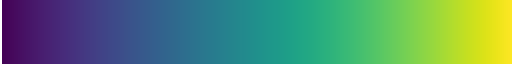

In [24]:
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

# let's display the areas where no expression is detected as transparent
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")
new_cmap

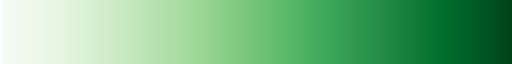

In [25]:
new_cmap_greens = set_zero_in_cmap_to_transparent(cmap="Greens")
new_cmap_greens

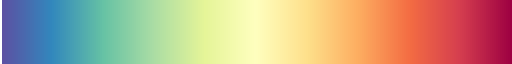

In [26]:
new_cmap_spectral = set_zero_in_cmap_to_transparent(cmap="Spectral_r")
new_cmap_spectral

In [27]:
sdata_blowup = sdata_small.query.bounding_box(
    min_coordinate=[0, 26000], max_coordinate=[2200, 28200], axes=("x", "y"), target_coordinate_system="Visium_HD_Human_Colon_Normal_P3"
)
sdata_blowup

SpatialData object
├── Images
│     ├── 'Visium_HD_Human_Colon_Normal_P3_full_image': DataTree[cyx] (3, 2200, 2200), (3, 1100, 1100), (3, 550, 550), (3, 275, 275), (3, 137, 138)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_hires_image': DataArray[cyx] (3, 164, 164)
│     └── 'Visium_HD_Human_Colon_Normal_P3_lowres_image': DataArray[cyx] (3, 16, 16)
├── Shapes
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_002um': GeoDataFrame shape: (74515, 1) (2D shapes)
│     ├── 'Visium_HD_Human_Colon_Normal_P3_square_008um': GeoDataFrame shape: (3262, 1) (2D shapes)
│     └── 'Visium_HD_Human_Colon_Normal_P3_square_016um': GeoDataFrame shape: (1215, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (74515, 18085)
      ├── 'square_008um': AnnData (3262, 18085)
      └── 'square_016um': AnnData (1215, 18085)
with coordinate systems:
    ▸ 'Visium_HD_Human_Colon_Normal_P3', with elements:
        Visium_HD_Human_Colon_Normal_P3_full_image (Images), Visium_HD_Human_Colon_Normal_P3_hires_ima

In [28]:
ELSE_STR = "else"
LP_STR = "Lamina Propria"
CRYPT_STR = "Crypt epithelium"
INTER_CRYPT_STR = "Inter-crypt Epithlium"
MUSCLE_STR = "Muscularis"
TISSUE_STR = "Tissue"
EPITHEIUM_STR = "Epithelium"
SUBMUCOSA_STR = "Submucosa"

knn_path = fig_path+"/K-Means 6.csv"
knn_df = pd.read_csv(knn_path)

knn_dict = {"Cluster 1":SUBMUCOSA_STR, "Cluster 2":SUBMUCOSA_STR+"-MM","Cluster 3":MUSCLE_STR,
            "Cluster 4":LP_STR, "Cluster 5":CRYPT_STR, "Cluster 6":INTER_CRYPT_STR}
n_clusters = len(knn_dict)

knn_df.index = knn_df['Barcode']
knn_df.rename(columns={"6":"cluster"}, inplace=True)
knn_df['cluster_name'] = knn_df['cluster'].map(knn_dict)
knn_df.head()

,Barcode,cluster,cluster_name
Barcode,,,
s_008um_00301_00321-1,s_008um_00301_00321-1,Cluster 2,Submucosa-MM
s_008um_00602_00290-1,s_008um_00602_00290-1,Cluster 2,Submucosa-MM
s_008um_00425_00829-1,s_008um_00425_00829-1,Cluster 3,Muscularis
s_008um_00526_00291-1,s_008um_00526_00291-1,Cluster 4,Lamina Propria
s_008um_00681_00396-1,s_008um_00681_00396-1,Cluster 1,Submucosa


In [29]:
# map cluster_name to integers
cluster_name_to_int = dict()
cluster_name_to_int["Muscularis"] = 0
cluster_name_to_int["Lamina Propria"] = 1
cluster_name_to_int["Submucosa-MM"] = 2
cluster_name_to_int["Submucosa"] = 3
cluster_name_to_int["Crypt epithelium"] = 4
cluster_name_to_int["Inter-crypt Epithlium"] = 5

In [30]:
sdata_blowup.tables['square_008um'].obs['cluster'] = knn_df.loc[sdata_blowup.tables['square_008um'].obs.index].cluster_name
sdata_blowup.tables['square_008um'].obs['cluster_int'] = sdata_blowup.tables['square_008um'].obs['cluster'].map(cluster_name_to_int)

In [31]:
knn_df.loc[np.intersect1d(sdata.tables['square_008um'].obs.index, knn_df.index)]

,Barcode,cluster,cluster_name
Barcode,,,
s_008um_00000_00403-1,s_008um_00000_00403-1,Cluster 6,Inter-crypt Epithlium
s_008um_00000_00404-1,s_008um_00000_00404-1,Cluster 6,Inter-crypt Epithlium
s_008um_00000_00405-1,s_008um_00000_00405-1,Cluster 6,Inter-crypt Epithlium
s_008um_00000_00406-1,s_008um_00000_00406-1,Cluster 6,Inter-crypt Epithlium
s_008um_00000_00407-1,s_008um_00000_00407-1,Cluster 6,Inter-crypt Epithlium
...,...,...,...
s_008um_00837_00466-1,s_008um_00837_00466-1,Cluster 4,Lamina Propria
s_008um_00837_00467-1,s_008um_00837_00467-1,Cluster 1,Submucosa
s_008um_00837_00468-1,s_008um_00837_00468-1,Cluster 1,Submucosa


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3010204..1.0].
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


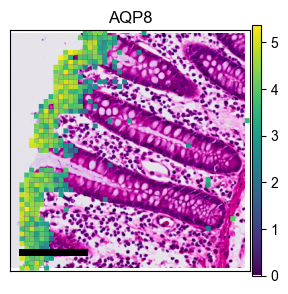

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3010204..1.0].
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


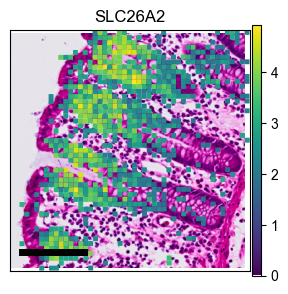

In [32]:
max_y = 26700
min_x = 400
square_side = 1400
sdata_blowup2 = sdata_small.query.bounding_box(
    min_coordinate=[min_x, max_y-square_side], max_coordinate=[min_x+square_side, max_y], axes=("x", "y"), target_coordinate_system="Visium_HD_Human_Colon_Normal_P3"
)
my_gene_names = ["AQP8", "SLC26A2"]
# my_gene_names = ["ISG15"]
for gene_name in my_gene_names:
    for bin_size in [8]:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
        sdata_blowup2.pl.render_images(full_res_name).pl.render_shapes(
            f"Visium_HD_Human_Colon_Normal_P3_square_{bin_size:03}um", color=gene_name, cmap=new_cmap,method='matplotlib',
        ).pl.show(coordinate_systems="Visium_HD_Human_Colon_Normal_P3", ax=ax)
        plt.title(f"{gene_name}")

        cbar = ax.collections[0].colorbar
        cbar.ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # hide x and y ticks
        plt.xticks([])
        plt.yticks([])

        # add short horizontal line as scale bar
        scalebar_length_um = 100
        scalebar_start_um = 20
        start_bar = min_x + scalebar_start_um / scalefactors['microns_per_pixel']
        end_bar = start_bar + scalebar_length_um / scalefactors['microns_per_pixel']
        plt.plot([start_bar, end_bar], [max_y-100, max_y-100], color='black', linewidth=5)

        # plt.title(f"{gene_name} bin_size={bin_size}µm")
        plt.tight_layout()
        plt.show()
        if EXPORT_FLAG:
            fig.savefig(fig_path+f"blowup2_{gene_name}.pdf", bbox_inches='tight')

### Plot blowups

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25615764..1.0].
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


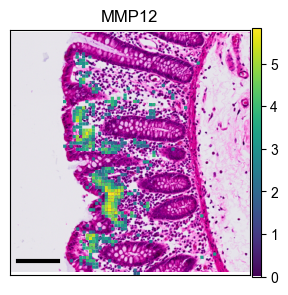

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25615764..1.0].
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


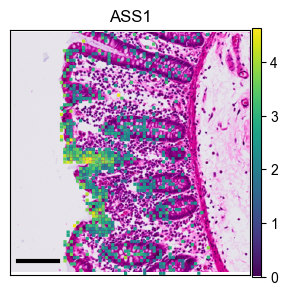

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25615764..1.0].
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


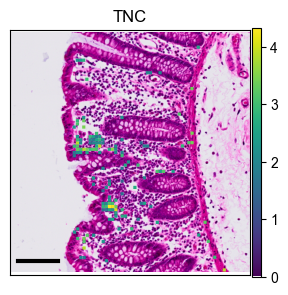

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25615764..1.0].
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


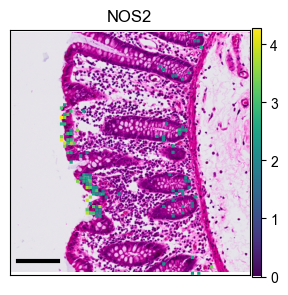

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25615764..1.0].
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Visium_HD_Human_Colon_Normal_P3_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


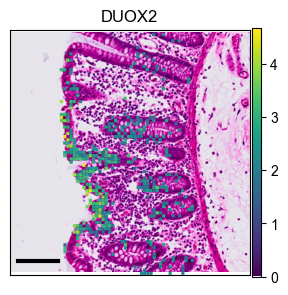

In [33]:
# my_gene_names = ["TNC"]
my_gene_names = ["MMP12","ASS1","TNC","NOS2","DUOX2"]

for gene_name in my_gene_names:
    for bin_size in [8]:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
        sdata_blowup.pl.render_images(full_res_name).pl.render_shapes(
            f"Visium_HD_Human_Colon_Normal_P3_square_{bin_size:03}um", color=gene_name, cmap=new_cmap,method='matplotlib',
        ).pl.show(coordinate_systems="Visium_HD_Human_Colon_Normal_P3", ax=ax)
        plt.title(f"{gene_name}")

        cbar = ax.collections[0].colorbar
        cbar.ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # hide x and y ticks
        plt.xticks([])
        plt.yticks([])

        # add short horizontal line as scale bar
        scalebar_length_um = 100
        scalebar_start_um = 20
        start_bar = scalebar_start_um / scalefactors['microns_per_pixel']
        end_bar = start_bar + scalebar_length_um / scalefactors['microns_per_pixel']
        plt.plot([start_bar, end_bar], [28100, 28100], color='black', linewidth=3)

        # Get the current image from the axis
        # im = ax.get_images()[0]

        # # Add a colorbar with the same height as the image
        # from mpl_toolkits.axes_grid1 import make_axes_locatable
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes("right", size="5%", pad=0.1)
        # plt.colorbar(im, cax=cax)

        # plt.title(f"{gene_name} bin_size={bin_size}µm")
        plt.tight_layout()
        plt.show()
        if EXPORT_FLAG:
            fig.savefig(fig_path+f"blowup_{gene_name}.pdf", bbox_inches='tight')

In [34]:
print(datetime.now())

2025-07-04 07:49:28.432979
